# Movie Matrix Decomposition

This notebook demonstrates matrix decomposition with the [MovieLens 25M data set](https://grouplens.org/datasets/movielens/).

## Setup

Import useful PyData modules:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

And some SciKit-Learn:

In [2]:
from sklearn.decomposition import TruncatedSVD

## Data

In [3]:
movies = pd.read_csv('ml-25m/movies.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


We're going to index that by movie ID:

In [4]:
movies.set_index('movieId', inplace=True)

And now load the ratings:

In [5]:
ratings = pd.read_csv('ml-25m/ratings.csv', dtype={
    'movieId': 'int32',
    'userId': 'int32',
    'rating': 'float32'
})
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float32
 3   timestamp  int64  
dtypes: float32(1), int32(2), int64(1)
memory usage: 476.8 MB


And load the movie tags:

In [6]:
tags = pd.read_csv('ml-25m/tags.csv', dtype={
    'movieId': 'int32',
    'userId': 'int32',
    'tag': 'string'
})
tags.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int32 
 1   movieId    1093360 non-null  int32 
 2   tag        1093344 non-null  string
 3   timestamp  1093360 non-null  int64 
dtypes: int32(2), int64(1), string(1)
memory usage: 25.0 MB


How many different tags are there?

In [7]:
tags['tag'].nunique()

73050

## Decomposing Movie-Tags

Let's count the number of times each tag is applied to each movie:

In [8]:
movie_tag_counts = tags.groupby(['movieId', 'tag'])['userId'].count().reset_index(name='count')
movie_tag_counts.head()

,movieId,tag,count
0,1,2009 reissue in Stereoscopic 3-D,1
1,1,3D,3
2,1,55 movies every kid should see--Entertainment ...,1
3,1,American Animation,1
4,1,Animation,1


Now, we want to make a matrix. But this matrix would be 64K by 73K, which is:

In [9]:
64000 * 73000 * 8 / (1024 * 1024)

35644.53125

That's about 35GB.  My desktop is that big, but it's still a lot.

Let's make a **sparse matrix**.  We are going to start by making a matrix in **coordinate format**: a set of triples of the form $(i, j, x_{ij})$, where $i$ is the row number and $j$ is the column number.

In order to do this, though, we need identifiers that are **contiguous** and **zero-based**.  Fortunately, this is exactly what the Pandas `Index` data structure does — it maps between index keys (of whatever type and value range) and contiguous, zero-based identifiers.

The `movies` frame had a movie index, since we indexed it by movie ID.

In [10]:
movies.index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            209145, 209147, 209151, 209153, 209155, 209157, 209159, 209163,
            209169, 209171],
           dtype='int64', name='movieId', length=62423)

The `get_indexer` method will convert a column of movie IDs to 0-based indexes:

In [11]:
mt_row = movies.index.get_indexer(movie_tag_counts['movieId'])
mt_row

array([    0,     0,     0, ..., 62391, 62391, 62391], dtype=int64)

In [12]:
nmovies = len(movies)

Let's make sure it found all the movies:

In [13]:
all(mt_row >= 0)

True

If it didn't find a movie, it would have returned a negative index.

Now, let's make an index for the tags.  We'll start by creating one for the unique tags, and we'll use `np.unique` so the tags are in sorted order, and we'll lowercase them first:

In [14]:
tag_idx = pd.Index(np.unique(movie_tag_counts['tag'].str.lower()))
tag_idx

Index([' alexander skarsgård', ' ballet school', ' breakup',
       ' difficult to find it', ' filmes antigos', ' filmes antigos ',
       ' kartik aaryan', ' kriti sanon', ' laurel canyon', ' luis brandoni',
       ...
       '惊悚', '扭曲', '斯巴达克斯:竞技场之神', '斯巴达克斯：前传', '斯巴达克斯：竞技场之神', '淘金记 莫声版', '独闯龙潭',
       '臥底', '魔鬼司令', '카운트다운'],
      dtype='object', length=65464)

In [15]:
ntags = len(tag_idx)

Now we'll get the column indexes:

In [16]:
mt_col = tag_idx.get_indexer(movie_tag_counts['tag'].str.lower())
mt_col

array([  468,   568,   623, ..., 46479, 46834, 58286], dtype=int64)

In [17]:
all(mt_col >= 0)

True

Now we are ready to make a sparse matrix.  We're going to store the matrix in Compress Sparse Row (CSR) form, using [`csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix); its constructor can take a matrix in COO (coordinate) form, which is what we just created.  Not every movie ID is used, so we're going to specify th size of the resulting matrix; some rows will be all 0.

We're also going to take the log of the counts (plus one), to reduce skew while preserving 0s (since $\operatorname{log} (0 + 1) = 0$).

So let's make it, and call it `mt_mat` for "movie tag matrix"

In [18]:
mt_mat = csr_matrix((np.log1p(movie_tag_counts['count']), (mt_row, mt_col)), (nmovies, ntags))
mt_mat

<62423x65464 sparse matrix of type '<class 'numpy.float64'>'
	with 463518 stored elements in Compressed Sparse Row format>

Woot! We now have have a sparse matrix whose rows are movies, columns are tags, and values are the number of times that tag has been applied to that movie.

We could have done that with a custom transformer.

Now let's train a `TruncatedSVD` that will project our tag matrix into 5 dimensions.  Remember it will learn:

$$X = P \Sigma Q^T$$

`fit` stores `Q` in the SVD, but throws away `P` - `P` is the result of a `transform`.  If we call `fit_transform`, it will store `Q` and return `P`.  Let's do it:

In [19]:
mt_svd = TruncatedSVD(5)
mt_P = mt_svd.fit_transform(mt_mat)

Now `mt_P` stores $P$, and `mt_svd.components_` stores $Q^T$.

`mt_P` has a row for each movie, since those were the rows of our input matrix.

Let's plot the first two dimensions of this vector space, so that each point is a movie:

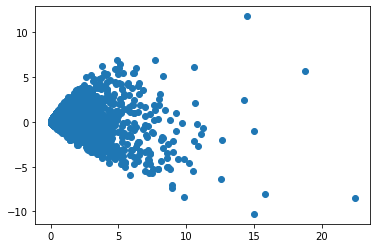

In [20]:
plt.scatter(mt_P[:, 0], mt_P[:, 1])

We can also plot all 5 dimensions with a pairplot.  First we're going to convert this to a data frame with named columns and a movie ID index:

In [21]:
mt_P_df = pd.DataFrame(mt_P, columns=[f'MD{i}' for i in range(mt_P.shape[1])], index=movies.index)
mt_P_df.head()

,MD0,MD1,MD2,MD3,MD4
movieId,,,,,
1,4.975549,5.328504,5.123646,-1.189267,0.528105
2,1.403948,0.203481,1.043021,-1.659741,-0.595791
3,0.227421,0.262806,0.274965,0.162643,0.026150
4,0.144859,0.098318,-0.005974,0.057476,-0.116541
5,0.372356,0.449867,0.354281,-0.095826,0.008303


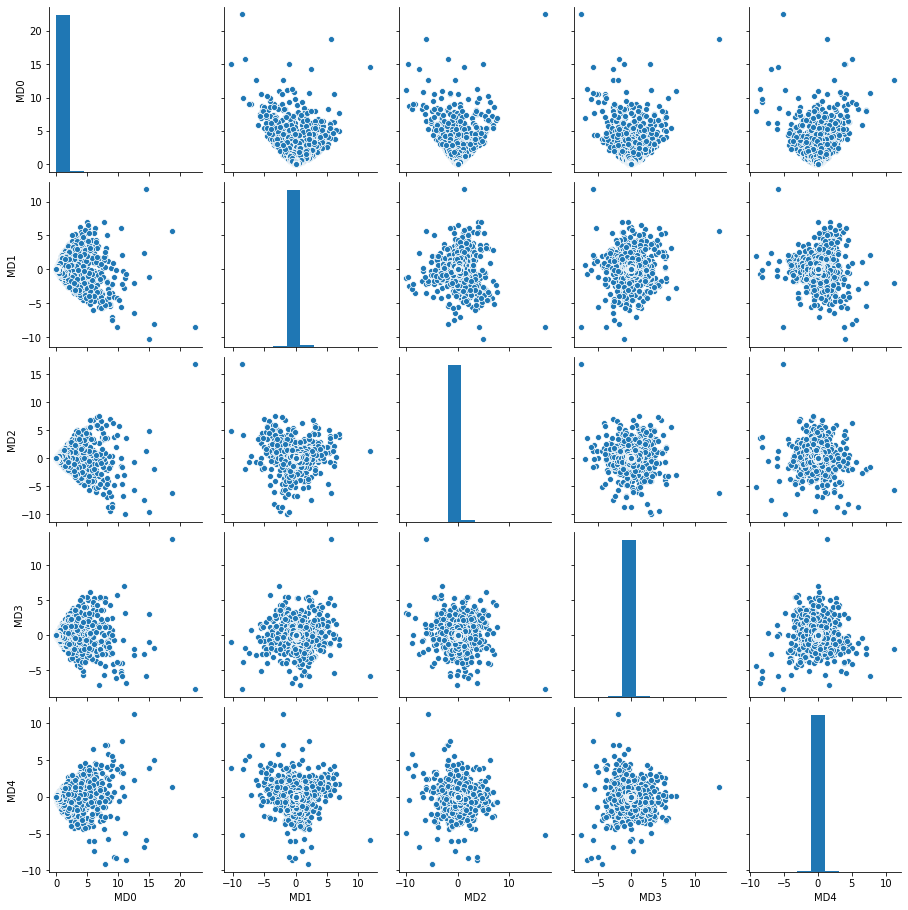

In [22]:
sns.pairplot(mt_P_df)

We can see that the first dimension (0) has a point that is close to a right angle; an SVD gives us **orthogonal** dimensions.

Now, let's see what movies have the highest 0 dimension.  Since we have a data frame, we can use `nlargest`:

In [23]:
mt_P_df.nlargest(5, 'MD0')

,MD0,MD1,MD2,MD3,MD4
movieId,,,,,
260,22.462252,-8.466508,16.765136,-7.705190,-5.162488
296,18.786882,5.663466,-6.104237,13.731377,1.411248
79132,15.794102,-8.038224,-1.889724,-1.827832,5.055682
2959,15.044625,-1.071897,-9.625266,3.079433,3.910763
2571,15.021538,-10.273176,4.950140,-1.015959,3.954582


But these aren't meaningful. Let's join with `movies` to get titles:

In [24]:
mt_P_df.nlargest(5, 'MD0').join(movies['title'])

,MD0,MD1,MD2,MD3,MD4,title
movieId,,,,,,
260,22.462252,-8.466508,16.765136,-7.705190,-5.162488,Star Wars: Episode IV - A New Hope (1977)
296,18.786882,5.663466,-6.104237,13.731377,1.411248,Pulp Fiction (1994)
79132,15.794102,-8.038224,-1.889724,-1.827832,5.055682,Inception (2010)
2959,15.044625,-1.071897,-9.625266,3.079433,3.910763,Fight Club (1999)
2571,15.021538,-10.273176,4.950140,-1.015959,3.954582,"Matrix, The (1999)"


What about the second dimension?

In [25]:
mt_P_df.nlargest(5, 'MD1').join(movies['title'])

,MD0,MD1,MD2,MD3,MD4,title
movieId,,,,,,
356,14.526421,11.795361,1.283543,-5.822479,-5.868638,Forrest Gump (1994)
1197,7.738679,6.938436,3.866916,-1.371170,0.029446,"Princess Bride, The (1987)"
4306,4.914259,6.918061,4.411453,-0.466859,1.774408,Shrek (2001)
46578,5.090094,6.496026,0.156534,1.678212,3.066294,Little Miss Sunshine (2006)
4886,3.782889,6.223932,3.952054,0.045252,1.820286,"Monsters, Inc. (2001)"


Up to you whether you think these have a meaningful relationship.

What are the top *tags* for the first dimension - that is another interesting question.

I'm going to take a slightly different approach this time.  I'm going to use `np.argsort`, which returns indexes corresponding to the sorted order of a NumPy array. The **last** ones will be the largest values.  If I argsort a row of the `mt_svd.components_` matrix, it will sort the tags by that feature; I can use the tag IDs of the highest-valued tags to get the tag names from the tag index.

Let's go!

In [26]:
tag_idx[np.argsort(mt_svd.components_[0, :])[-5:]]

Index(['funny', 'based on a book', 'atmospheric', 'sci-fi', 'action'], dtype='object')

This means that movies with these tags will score highly on this feature.

Since there is a popularity component to our data (people add more tags to popular movies), there is a very good chance that the first feature will effectively be *popularity*.

## Your Turn

We can also decompose the *ratings* matrix: users rating movies.

What are the top movies if we do that?